In [21]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pandasql as psql
from pandasql import sqldf
import sqlite3
from scipy.stats import pearsonr, norm, stats, ttest_1samp
import matplotlib.pyplot as plt
%matplotlib inline

### Extract the data from the box office gross dataset

In [22]:
bom_gross_data = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
bom_gross_data

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [23]:
bom_gross_data.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [24]:
bom_gross_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### Extract the data from the imdb database using SQLite

In [25]:
# Connect to the SQLite database
conn = sqlite3.connect('./zippedData/im.db/im.db')

# Load tables into DataFrames
movie_basics_df = pd.read_sql_query("SELECT * FROM movie_basics;", conn)
directors_df = pd.read_sql_query("SELECT * FROM directors;", conn)
known_for_df = pd.read_sql_query("SELECT * FROM known_for;", conn)
movie_akas_df = pd.read_sql_query("SELECT * FROM movie_akas;", conn)
movie_ratings_df = pd.read_sql_query("SELECT * FROM movie_ratings;", conn)
persons_df = pd.read_sql_query("SELECT * FROM persons;", conn)
principals_df = pd.read_sql_query("SELECT * FROM principals;", conn)
writers_df = pd.read_sql_query("SELECT * FROM writers;", conn)

# Close the connection
conn.close()


In [26]:
# lambda function to simplify SQL querying
pysqldf = lambda q: sqldf(q, globals())


In [27]:
#test query
query1 = """SELECT * FROM movie_basics_df
            WHERE start_year > 2015"""
result1 = pysqldf(query1)
# print(result1)
result1


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
1,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
2,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
3,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
4,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
...,...,...,...,...,...,...
61062,tt9916186,Illenau - die Geschichte einer ehemaligen Heil...,Illenau - die Geschichte einer ehemaligen Heil...,2017,84.0,Documentary
61063,tt9916190,Safeguard,Safeguard,2019,90.0,"Drama,Thriller"
61064,tt9916428,The Secret of China,The Secret of China,2019,NaN,"Adventure,History,War"
61065,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama


In [28]:
movie_basics_df.head()


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [32]:
def save_df_to_directory(df, directory, filename):
    """
    Saves a DataFrame to a specified directory with the given file name.

    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    directory (str): The directory where the DataFrame will be saved.
    file_name (str): The name of the file to save the DataFrame as.
    """
    #ensure the os exists
    os.makedirs(directory, exist_ok=True)

    #create the full path
    file_path = os.path.join(directory, filename)

    #save the dataframe as a csv file
    df.to_csv(file_path, index="False")

In [33]:
save_df_to_directory(movie_basics_df, './accessible_data/', 'movie_basics_df.csv')

In [9]:
movie_ratings_df.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [34]:
save_df_to_directory(movie_ratings_df, './accessible_data/', 'movie_ratings_df')

In [10]:
print('Movie Basic DF')
print(movie_basics_df.describe())
print()
print('Box office gross dataframe')
print(bom_gross_data.describe())

Movie Basic DF
          start_year  runtime_minutes
count  146144.000000    114405.000000
mean     2014.621798        86.187247
std         2.733583       166.360590
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2015.000000        87.000000
75%      2017.000000        99.000000
max      2115.000000     51420.000000

Box office gross dataframe
       domestic_gross         year
count    3.359000e+03  3387.000000
mean     2.874585e+07  2013.958075
std      6.698250e+07     2.478141
min      1.000000e+02  2010.000000
25%      1.200000e+05  2012.000000
50%      1.400000e+06  2014.000000
75%      2.790000e+07  2016.000000
max      9.367000e+08  2018.000000


In [35]:
save_df_to_directory(bom_gross_data,'./accessible_data/', 'bom_gross_df')

In [36]:
#identify missing values in bom_gross_data
bom_gross_data.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [37]:
#identify missing values in movie_ratings_df
movie_ratings_df.isnull().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

In [38]:
#identify missing values in movie_basics_df
movie_basics_df.isnull().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

##### Remove outliers from the data

In [39]:
# # Function to remove outliers using IQR method
# def remove_outliers(df, column):
#     # Convert to numeric
#     df[column] = pd.to_numeric(df[column], errors='coerce')
#     # Drop missing values
#     col_data = df[column].dropna()
    
#     # Calculate Q1, Q3, and IQR
#     Q1 = col_data.quantile(0.25)
#     Q3 = col_data.quantile(0.75)
#     IQR = Q3 - Q1
    
#     # Define lower and upper bounds for outliers
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     # Filter out outliers
#     filtered_data = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
#     return filtered_data


In [40]:
# # Remove outliers for both columns
# filtered_data_domestic = remove_outliers(bom_gross_data, 'domestic_gross')
# filtered_data_foreign = remove_outliers(bom_gross_data, 'foreign_gross')

# # Ensure that both columns are free of outliers
# filtered_data = filtered_data_domestic.merge(filtered_data_foreign, on=bom_gross_data.columns.tolist(), how='inner')

In [41]:
# filtered_data

In [42]:
# # Calculate measures of central tendency and dispersion
# columns_of_interest = ['domestic_gross', 'foreign_gross']

# # Initialize a dictionary to store the results
# statistics = {}

# for column in columns_of_interest:
#     # Drop missing values for each column before computation
#     bom_gross_data[column] = pd.to_numeric(bom_gross_data[column], errors='coerce')
#     col_data = bom_gross_data[column].dropna()
    
#     # Central tendency
#     mean = col_data.mean()
#     median = col_data.median()
#     mode = col_data.mode().values[0] if not col_data.mode().empty else None
    
#     # Dispersion
#     data_range = col_data.max() - col_data.min()
#     variance = col_data.var()
#     std_dev = col_data.std()
#     iqr = col_data.quantile(0.75) - col_data.quantile(0.25)
    
#     # Store the results in the dictionary
#     statistics[column] = {
#         'mean': mean,
#         'median': median,
#         'mode': mode,
#         'range': data_range,
#         'variance': variance,
#         'standard_deviation': std_dev,
#         'IQR': iqr
#     }

# statistics


In [43]:
# Merge the dataframes on the movie title
df_merged = pd.merge(bom_gross_data, movie_basics_df, left_on='title', right_on='primary_title', how='left')
df_merged

,title,studio,domestic_gross,foreign_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,Toy Story 3,BV,415000000.0,652000000,2010,tt0435761,Toy Story 3,Toy Story 3,2010.0,103.0,"Adventure,Animation,Comedy"
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,WB,292600000.0,535700000,2010,tt1375666,Inception,Inception,2010.0,148.0,"Action,Adventure,Sci-Fi"
4,Shrek Forever After,P/DW,238700000.0,513900000,2010,tt0892791,Shrek Forever After,Shrek Forever After,2010.0,93.0,"Adventure,Animation,Comedy"
...,...,...,...,...,...,...,...,...,...,...,...
4142,The Quake,Magn.,6200.0,NaN,2018,tt6523720,The Quake,Skjelvet,2018.0,106.0,"Action,Drama,Thriller"
4143,Edward II (2018 re-release),FM,4800.0,NaN,2018,NaN,NaN,NaN,NaN,NaN,NaN
4144,El Pacto,Sony,2500.0,NaN,2018,NaN,NaN,NaN,NaN,NaN,NaN
4145,The Swan,Synergetic,2400.0,NaN,2018,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Convert gross columns to numeric, coercing errors to NaN
df_merged['domestic_gross'] = pd.to_numeric(bom_gross_data['domestic_gross'], errors='coerce')
df_merged['foreign_gross'] = pd.to_numeric(bom_gross_data['foreign_gross'], errors='coerce')


# Fill missing values with the mean
df_merged['domestic_gross'].fillna(df_merged['domestic_gross'].mean(), inplace=True)
df_merged['foreign_gross'].fillna(df_merged['foreign_gross'].mean(), inplace=True)

df_merged

,title,studio,domestic_gross,foreign_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,Toy Story 3,BV,4.150000e+08,6.520000e+08,2010,tt0435761,Toy Story 3,Toy Story 3,2010.0,103.0,"Adventure,Animation,Comedy"
1,Alice in Wonderland (2010),BV,3.342000e+08,6.913000e+08,2010,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,WB,2.960000e+08,6.643000e+08,2010,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,WB,2.926000e+08,5.357000e+08,2010,tt1375666,Inception,Inception,2010.0,148.0,"Action,Adventure,Sci-Fi"
4,Shrek Forever After,P/DW,2.387000e+08,5.139000e+08,2010,tt0892791,Shrek Forever After,Shrek Forever After,2010.0,93.0,"Adventure,Animation,Comedy"
...,...,...,...,...,...,...,...,...,...,...,...
4142,The Quake,Magn.,2.874585e+07,7.505704e+07,2018,tt6523720,The Quake,Skjelvet,2018.0,106.0,"Action,Drama,Thriller"
4143,Edward II (2018 re-release),FM,2.874585e+07,7.505704e+07,2018,NaN,NaN,NaN,NaN,NaN,NaN
4144,El Pacto,Sony,2.874585e+07,7.505704e+07,2018,NaN,NaN,NaN,NaN,NaN,NaN
4145,The Swan,Synergetic,2.874585e+07,7.505704e+07,2018,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
save_df_to_directory(df_merged, './accessible_data/', 'bom_basics_merged_df')

### Descriptive Breakdown

In [46]:
# movie_basics_df = movie_basics_df.dropna()
# movie_ratings_df = movie_ratings_df.dropna()

In [47]:
# Calculate total and average gross by year
gross_by_year = df_merged.groupby('year').agg(
    total_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='sum'),
    average_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='mean'),
    total_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='sum'),
    average_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='mean')
).reset_index()

gross_by_year

,year,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,2010,1.810246e+10,4.536956e+07,2.839216e+10,7.115829e+07
1,2011,1.295417e+10,2.682023e+07,2.744150e+10,5.681470e+07
2,2012,1.136210e+10,2.333080e+07,3.142733e+10,6.453250e+07
3,2013,1.046567e+10,2.480016e+07,3.063419e+10,7.259286e+07
4,2014,1.108408e+10,2.353307e+07,3.607043e+10,7.658264e+07
5,2015,2.040815e+10,3.612061e+07,5.953017e+10,1.053631e+08
6,2016,1.298453e+10,2.477963e+07,3.809541e+10,7.270116e+07
7,2017,1.092445e+10,2.626071e+07,3.114870e+10,7.487669e+07
8,2018,1.092342e+10,2.874585e+07,2.852168e+10,7.505704e+07


In [52]:
query2 = '''SELECT *
FROM gross_by_year
WHERE year > 2012
ORDER BY total_foreign_gross ASC'''

results2 = pysqldf(query2)
results2

,year,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,2018,1.092342e+10,2.874585e+07,2.852168e+10,7.505704e+07
1,2013,1.046567e+10,2.480016e+07,3.063419e+10,7.259286e+07
2,2017,1.092445e+10,2.626071e+07,3.114870e+10,7.487669e+07
3,2014,1.108408e+10,2.353307e+07,3.607043e+10,7.658264e+07
4,2016,1.298453e+10,2.477963e+07,3.809541e+10,7.270116e+07
5,2015,2.040815e+10,3.612061e+07,5.953017e+10,1.053631e+08


In [22]:
df_merged

,title,studio,domestic_gross,foreign_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,Toy Story 3,BV,4.150000e+08,6.520000e+08,2010,tt0435761,Toy Story 3,Toy Story 3,2010.0,103.0,"Adventure,Animation,Comedy"
1,Alice in Wonderland (2010),BV,3.342000e+08,6.913000e+08,2010,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,WB,2.960000e+08,6.643000e+08,2010,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,WB,2.926000e+08,5.357000e+08,2010,tt1375666,Inception,Inception,2010.0,148.0,"Action,Adventure,Sci-Fi"
4,Shrek Forever After,P/DW,2.387000e+08,5.139000e+08,2010,tt0892791,Shrek Forever After,Shrek Forever After,2010.0,93.0,"Adventure,Animation,Comedy"
...,...,...,...,...,...,...,...,...,...,...,...
4142,The Quake,Magn.,2.874585e+07,7.505704e+07,2018,tt6523720,The Quake,Skjelvet,2018.0,106.0,"Action,Drama,Thriller"
4143,Edward II (2018 re-release),FM,2.874585e+07,7.505704e+07,2018,NaN,NaN,NaN,NaN,NaN,NaN
4144,El Pacto,Sony,2.874585e+07,7.505704e+07,2018,NaN,NaN,NaN,NaN,NaN,NaN
4145,The Swan,Synergetic,2.874585e+07,7.505704e+07,2018,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
query3 = '''SELECT title, studio, primary_title, genres
FROM df_merged
WHERE genres is NULL
GROUP BY studio
ORDER BY studio DESC'''

result3 = pysqldf(query3)
result3

,title,studio,primary_title,genres
0,Mid-August Lunch,Zeit.,None,None
1,Badmaash Company,Yash,None,None
2,Papa: Hemingway in Cuba,YFG,None,None
3,Jimi: All Is By My Side,XL,None,None
4,Nowhere Boy,Wein.,None,None
...,...,...,...,...
156,I (2015),AaF,None,None
157,Surprise - Journey To The West,AR,None,None
158,Sister (2012),AF,None,None
159,Under the Skin (2014),A24,None,None


In [66]:
# Split the genres column
df_merged.loc[df_merged.index, 'genres'] = df_merged['genres'].str.split(',')

# Explode the genres column
df_exploded = df_merged.explode('genres')

# Calculate total and average gross by year
gross_by_year = df_merged.groupby('year').agg(
    total_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='sum'),
    average_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='mean'),
    total_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='sum'),
    average_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='mean')
).reset_index()

In [67]:
# Calculate total and average gross by genre
gross_by_genre = df_exploded.groupby('genres').agg(
    total_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='sum'),
    average_domestic_gross=pd.NamedAgg(column='domestic_gross', aggfunc='mean'),
    total_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='sum'),
    average_foreign_gross=pd.NamedAgg(column='foreign_gross', aggfunc='mean')
).reset_index()

In [25]:
gross_by_year

,year,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,2010,1.810246e+10,4.536956e+07,2.839216e+10,7.115829e+07
1,2011,1.295417e+10,2.682023e+07,2.744150e+10,5.681470e+07
2,2012,1.136210e+10,2.333080e+07,3.142733e+10,6.453250e+07
3,2013,1.046567e+10,2.480016e+07,3.063419e+10,7.259286e+07
4,2014,1.108408e+10,2.353307e+07,3.607043e+10,7.658264e+07
5,2015,2.040815e+10,3.612061e+07,5.953017e+10,1.053631e+08
6,2016,1.298453e+10,2.477963e+07,3.809541e+10,7.270116e+07
7,2017,1.092445e+10,2.626071e+07,3.114870e+10,7.487669e+07
8,2018,1.092342e+10,2.874585e+07,2.852168e+10,7.505704e+07


In [68]:
save_df_to_directory(gross_by_year, './accessible_data/', 'gross_by_year')

In [27]:
gross_by_genre

,genres,total_domestic_gross,average_domestic_gross,total_foreign_gross,average_foreign_gross
0,Action,1.871434e+10,2.818424e+07,5.040060e+10,7.590452e+07
1,Adventure,1.281677e+10,2.873715e+07,3.505543e+10,7.859962e+07
2,Animation,5.063948e+09,3.225445e+07,1.332415e+10,8.486721e+07
3,Biography,8.981495e+09,2.935129e+07,2.392463e+10,7.818507e+07
4,Comedy,2.650787e+10,2.746929e+07,7.320100e+10,7.585596e+07
5,Crime,1.144127e+10,2.933659e+07,3.058473e+10,7.842240e+07
6,Documentary,9.343578e+09,2.797479e+07,2.278936e+10,6.823163e+07
7,Drama,5.258798e+10,2.803197e+07,1.396726e+11,7.445234e+07
8,Family,4.220046e+09,3.271354e+07,9.442665e+09,7.319895e+07
9,Fantasy,4.615254e+09,2.607488e+07,1.312587e+10,7.415749e+07


In [69]:
save_df_to_directory(gross_by_genre, './accessible_data/', 'gross_by_genre')

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

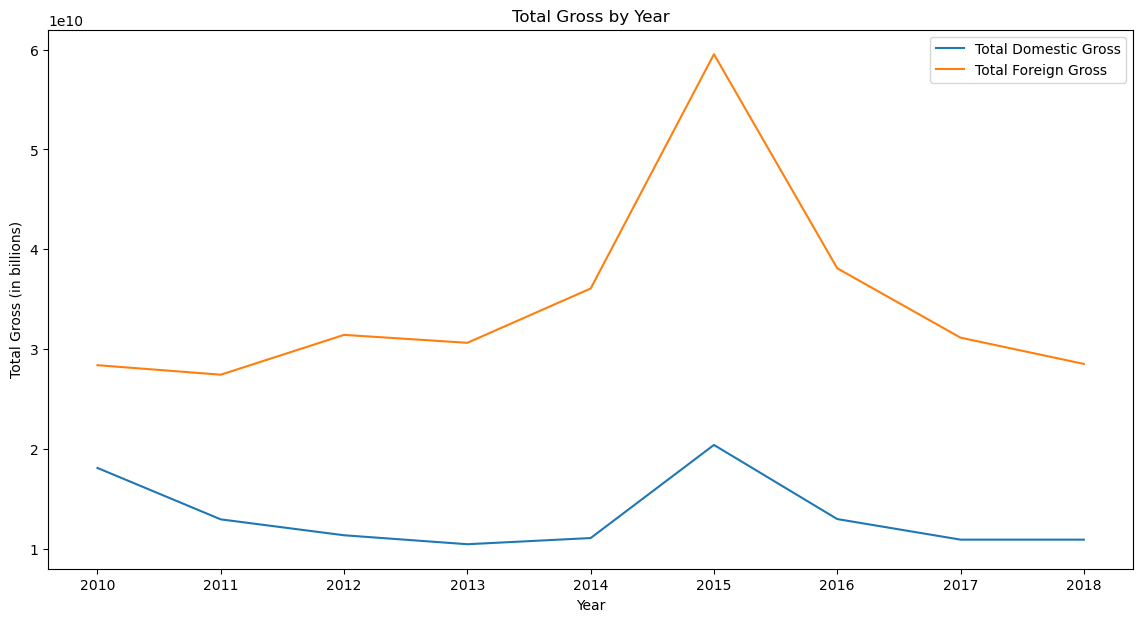

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

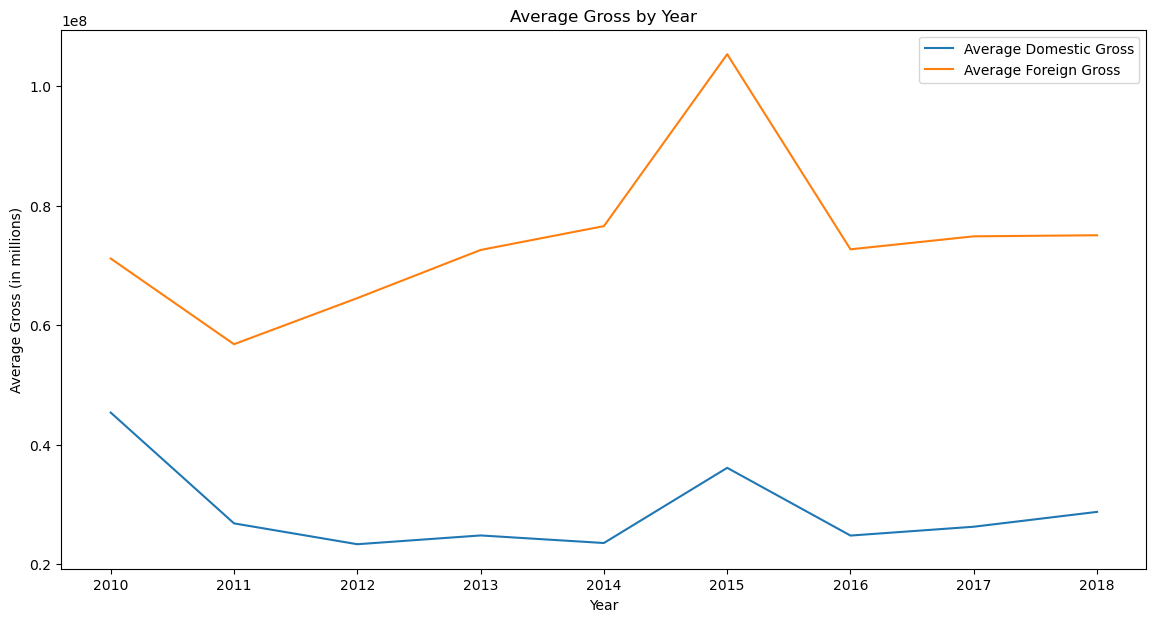

In [71]:
# Plot total and average gross by year
plt.figure(figsize=(14, 7))
sns.lineplot(data=gross_by_year, x='year', y='total_domestic_gross', label='Total Domestic Gross')
sns.lineplot(data=gross_by_year, x='year', y='total_foreign_gross', label='Total Foreign Gross')
plt.title('Total Gross by Year')
plt.xlabel('Year')
plt.ylabel('Total Gross (in billions)')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(data=gross_by_year, x='year', y='average_domestic_gross', label='Average Domestic Gross')
sns.lineplot(data=gross_by_year, x='year', y='average_foreign_gross', label='Average Foreign Gross')
plt.title('Average Gross by Year')
plt.xlabel('Year')
plt.ylabel('Average Gross (in millions)')
plt.legend()
plt.show()

In [73]:
plt.savefig('Total_gross_and_avg_by_year')

<Figure size 640x480 with 0 Axes>

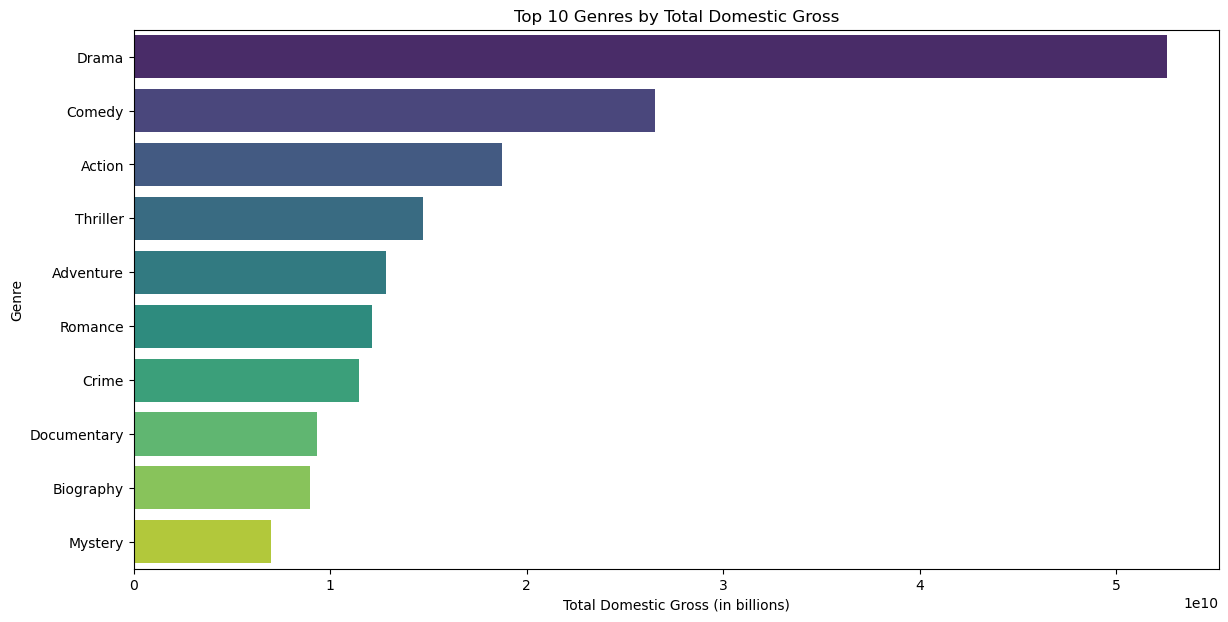

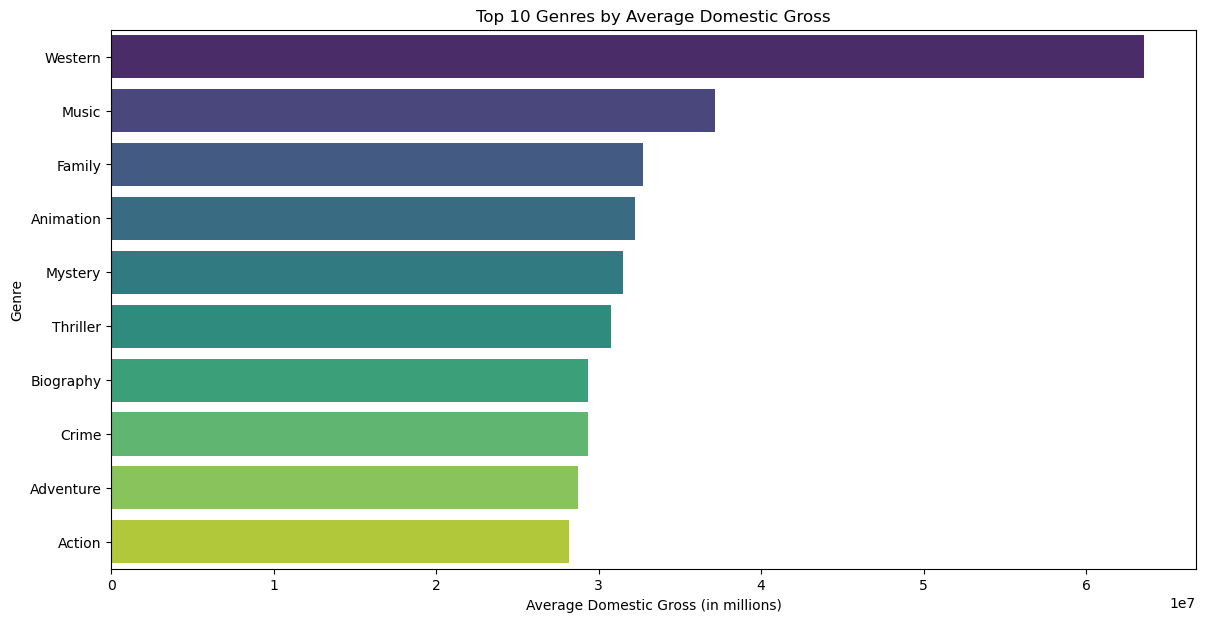

In [29]:
# Plot total and average gross by genre
plt.figure(figsize=(14, 7))
sns.barplot(data=gross_by_genre.sort_values(by='total_domestic_gross', ascending=False).head(10),
            x='total_domestic_gross', y='genres', palette='viridis')
plt.title('Top 10 Genres by Total Domestic Gross')
plt.xlabel('Total Domestic Gross (in billions)')
plt.ylabel('Genre')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(data=gross_by_genre.sort_values(by='average_domestic_gross', ascending=False).head(10),
            x='average_domestic_gross', y='genres', palette='viridis')
plt.title('Top 10 Genres by Average Domestic Gross')
plt.xlabel('Average Domestic Gross (in millions)')
plt.ylabel('Genre')
plt.show()

In [74]:
plt.savefig('Top10_genres_Domestic')

<Figure size 640x480 with 0 Axes>

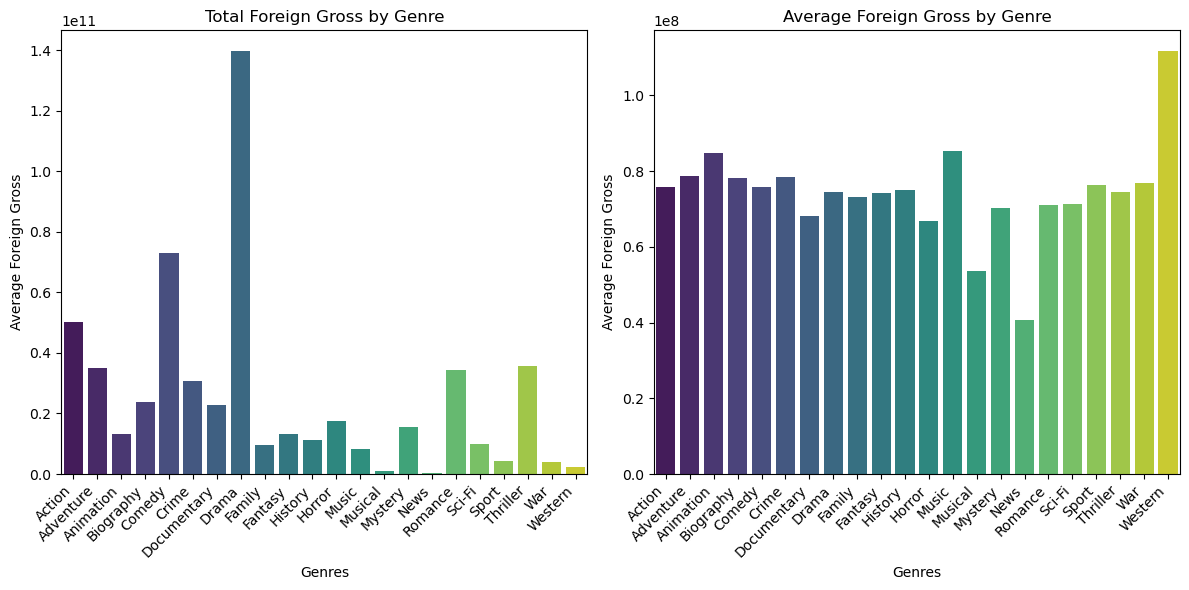

In [93]:
# Bar plot for average domestic and foreign gross by genre
plt.figure(figsize=(12, 6))

# Plot average domestic gross
plt.subplot(1, 2, 1)
sns.barplot(data=gross_by_genre, x='genres', y='total_foreign_gross', palette='viridis')
plt.title('Total Foreign Gross by Genre')
plt.xlabel('Genres')
plt.ylabel('Average Foreign Gross')
plt.xticks(rotation=45, ha='right')


# Plot average foreign gross
plt.subplot(1, 2, 2)
sns.barplot(data=gross_by_genre, x='genres', y='average_foreign_gross', palette='viridis')
plt.title('Average Foreign Gross by Genre')
plt.xlabel('Genres')
plt.ylabel('Average Foreign Gross')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

C:\Users\omend\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\omend\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
C:\Users\omend\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\omend\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


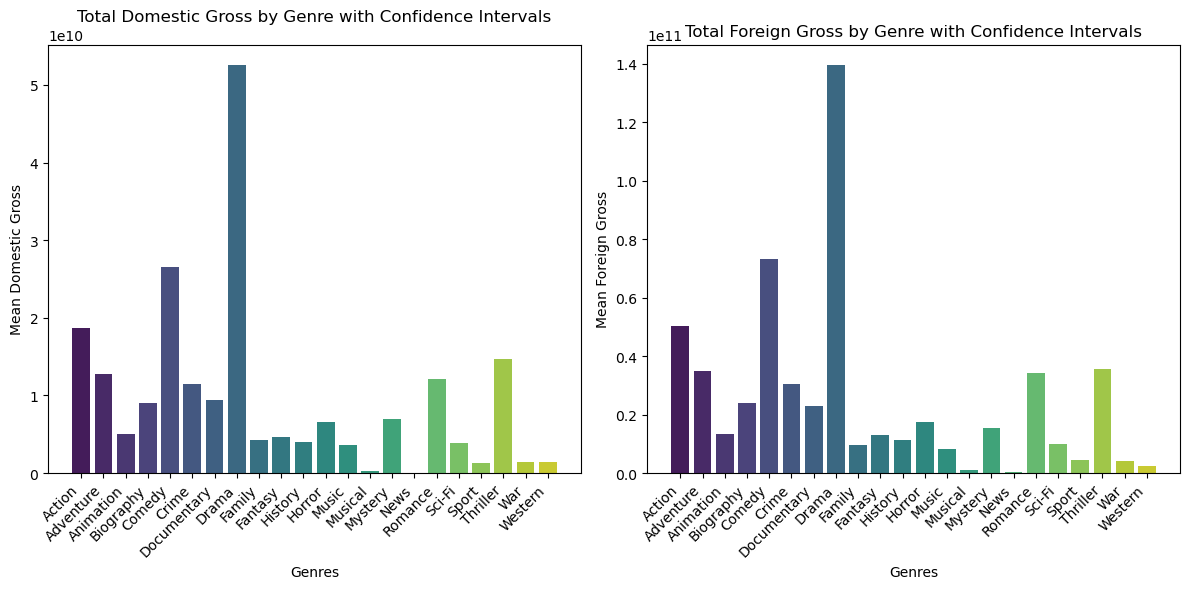

In [98]:
# Calculate mean and confidence intervals for each genre
gross_grouped = gross_by_genre.groupby('genres').agg(
    mean_domestic_gross=('total_domestic_gross', 'mean'),
    ci_domestic_gross=('total_domestic_gross', lambda x: 1.96 * x.std()/len(x)**0.5),
    mean_foreign_gross=('total_foreign_gross', 'mean'),
    ci_foreign_gross=('total_foreign_gross', lambda x: 1.96 * x.std()/len(x)**0.5)
).reset_index()

# Plot with confidence intervals
plt.figure(figsize=(12, 6))

# Plot total domestic gross with confidence intervals
plt.subplot(1, 2, 1)
sns.barplot(data=gross_grouped, x='genres', y='mean_domestic_gross', palette='viridis', errorbar='ci')
plt.errorbar(gross_grouped['genres'], gross_grouped['mean_domestic_gross'], yerr=gross_grouped['ci_domestic_gross'], fmt='none', c='black', capsize=5)
plt.title('Total Domestic Gross by Genre with Confidence Intervals')
plt.xlabel('Genres')
plt.ylabel('Mean Domestic Gross')
plt.xticks(rotation=45, ha='right')

# Plot total foreign gross with confidence intervals
plt.subplot(1, 2, 2)
sns.barplot(data=gross_grouped, x='genres', y='mean_foreign_gross', palette='viridis', errorbar='ci')
plt.errorbar(gross_grouped['genres'], gross_grouped['mean_foreign_gross'], yerr=gross_grouped['ci_foreign_gross'], fmt='none', c='black', capsize=5)
plt.title('Total Foreign Gross by Genre with Confidence Intervals')
plt.xlabel('Genres')
plt.ylabel('Mean Foreign Gross')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [106]:
#merge movie_ratings_df and movies_basics_df
merged_df = pd.merge(movie_basics_df, movie_ratings_df, on='movie_id')
merged_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,6.6,5


In [107]:
save_df_to_directory(merged_df, './accessible_data/', 'movie_ratings_and_basics.csv')

In [108]:
summary_stats = merged_df.describe()
print(summary_stats)

         start_year  runtime_minutes  averagerating      numvotes
count  73856.000000     66236.000000   73856.000000  7.385600e+04
mean    2014.276132        94.654040       6.332729  3.523662e+03
std        2.614807       208.574111       1.474978  3.029402e+04
min     2010.000000         3.000000       1.000000  5.000000e+00
25%     2012.000000        81.000000       5.500000  1.400000e+01
50%     2014.000000        91.000000       6.500000  4.900000e+01
75%     2016.000000       104.000000       7.400000  2.820000e+02
max     2019.000000     51420.000000      10.000000  1.841066e+06


In [109]:
# corr, _ = pearsonr(merged_df['runtime_minutes'], merged_df['averagerating'])
# print(f'Correlation between runtime and average rating: {corr}')

In [110]:
# Calculate descriptive statistics
descriptive_stats = merged_df[['averagerating', 'numvotes']].describe()
print(descriptive_stats)

       averagerating      numvotes
count   73856.000000  7.385600e+04
mean        6.332729  3.523662e+03
std         1.474978  3.029402e+04
min         1.000000  5.000000e+00
25%         5.500000  1.400000e+01
50%         6.500000  4.900000e+01
75%         7.400000  2.820000e+02
max        10.000000  1.841066e+06


In [111]:
# Calculate measures of central tendency and measurements of dispersion
mean_rating = merged_df['averagerating'].mean()
median_rating = merged_df['averagerating'].median()
mode_rating = merged_df['averagerating'].mode()[0]

std_dev_rating = merged_df['averagerating'].std()
variance_rating = merged_df['averagerating'].var()

mean_votes = merged_df['numvotes'].mean()
median_votes = merged_df['numvotes'].median()
mode_votes = merged_df['numvotes'].mode()[0]

std_dev_votes =merged_df['numvotes'].std()
variance_votes = merged_df['numvotes'].var()

print(f"Mean Rating: {mean_rating}")
print(f"Median Rating: {median_rating}")
print(f"Mode Rating: {mode_rating}")
print(f"Standard Deviation of Ratings: {std_dev_rating}")
print(f"Variance of Ratings: {variance_rating}")

print(f"Mean Votes: {mean_votes}")
print(f"Median Votes: {median_votes}")
print(f"Mode Votes: {mode_votes}")
print(f"Standard Deviation of Votes: {std_dev_votes}")
print(f"Variance of Votes: {variance_votes}")

Mean Rating: 6.332728552859619
Median Rating: 6.5
Mode Rating: 7.0
Standard Deviation of Ratings: 1.4749783548957582
Variance of Ratings: 2.1755611474109973
Mean Votes: 3523.6621669194105
Median Votes: 49.0
Mode Votes: 6
Standard Deviation of Votes: 30294.022971103946
Variance of Votes: 917727827.7737737


In [112]:
# Split the genres column
merged_df.loc[merged_df.index, 'genres'] = merged_df['genres'].str.split(',')

# Explode the genres column
exploded_df = merged_df.explode('genres')


In [113]:
# Calculate descriptive statistics for each genre
genre_stats = exploded_df.groupby('genres').agg(
    count=pd.NamedAgg(column='averagerating', aggfunc='count'),
    mean_rating=pd.NamedAgg(column='averagerating', aggfunc='mean'),
    median_rating=pd.NamedAgg(column='averagerating', aggfunc='median'),
    mode_rating=pd.NamedAgg(column='averagerating', aggfunc=lambda x: x.mode()[0]),
    std_dev_rating=pd.NamedAgg(column='averagerating', aggfunc='std'),
    variance_rating=pd.NamedAgg(column='averagerating', aggfunc='var'),
    mean_votes=pd.NamedAgg(column='numvotes', aggfunc='mean'),
    median_votes=pd.NamedAgg(column='numvotes', aggfunc='median'),
    mode_votes=pd.NamedAgg(column='numvotes', aggfunc=lambda x: x.mode()[0]),
    std_dev_votes=pd.NamedAgg(column='numvotes', aggfunc='std'),
    variance_votes=pd.NamedAgg(column='numvotes', aggfunc='var')
).reset_index()
genre_stats

,genres,count,mean_rating,median_rating,mode_rating,std_dev_rating,variance_rating,mean_votes,median_votes,mode_votes,std_dev_votes,variance_votes
0,Action,6988,5.810361,6.00,6.5,1.513833,2.291692,14476.485690,170.0,5,70102.991766,4.914429e+09
1,Adult,3,3.766667,3.40,2.0,1.975686,3.903333,54.666667,28.0,8,64.291005,4.133333e+03
2,Adventure,3817,6.196201,6.40,6.6,1.514963,2.295114,22067.746660,111.0,6,93018.384213,8.652420e+09
3,Animation,1743,6.248308,6.50,6.8,1.353982,1.833268,8808.549627,97.0,10,45339.233918,2.055646e+09
4,Biography,3809,7.162274,7.20,7.0,1.072788,1.150874,5673.259648,40.0,6,39346.364036,1.548136e+09
5,Comedy,17290,6.002689,6.10,6.2,1.404156,1.971653,4297.617409,95.0,6,28443.308108,8.090218e+08
6,Crime,4611,6.115441,6.20,6.5,1.340714,1.797514,8594.959011,169.0,6,41371.228672,1.711579e+09
7,Documentary,17753,7.332090,7.40,7.2,1.086263,1.179967,266.960232,19.0,5,1871.784743,3.503578e+06
8,Drama,30788,6.401559,6.50,6.2,1.277601,1.632264,3883.574769,71.0,6,28632.222464,8.198042e+08
9,Family,3412,6.394725,6.50,6.5,1.384528,1.916917,2531.274912,52.0,6,22860.575825,5.226059e+08


In [114]:
threshold = 500
filtered_df = merged_df[merged_df['runtime_minutes'] <= threshold]

In [119]:
filtered_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[Biography, Drama]",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama],6.9,4517
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[Comedy, Drama, Fantasy]",6.5,119
6,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"[Adventure, Animation, Comedy]",8.1,263
...,...,...,...,...,...,...,...,...
73849,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,[Drama],8.4,365
73850,tt9913056,Swarm Season,Swarm Season,2019,86.0,[Documentary],6.2,5
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,[Documentary],6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"[Drama, Family]",8.7,136


In [115]:
#descriptive statistics
avg_rating = np.mean(filtered_df['averagerating'])
median_runtime = np.median(filtered_df['runtime_minutes'])

In [116]:
avg_rating

6.321677286866186

In [117]:
median_runtime

91.0

### Distribution Plot of genre

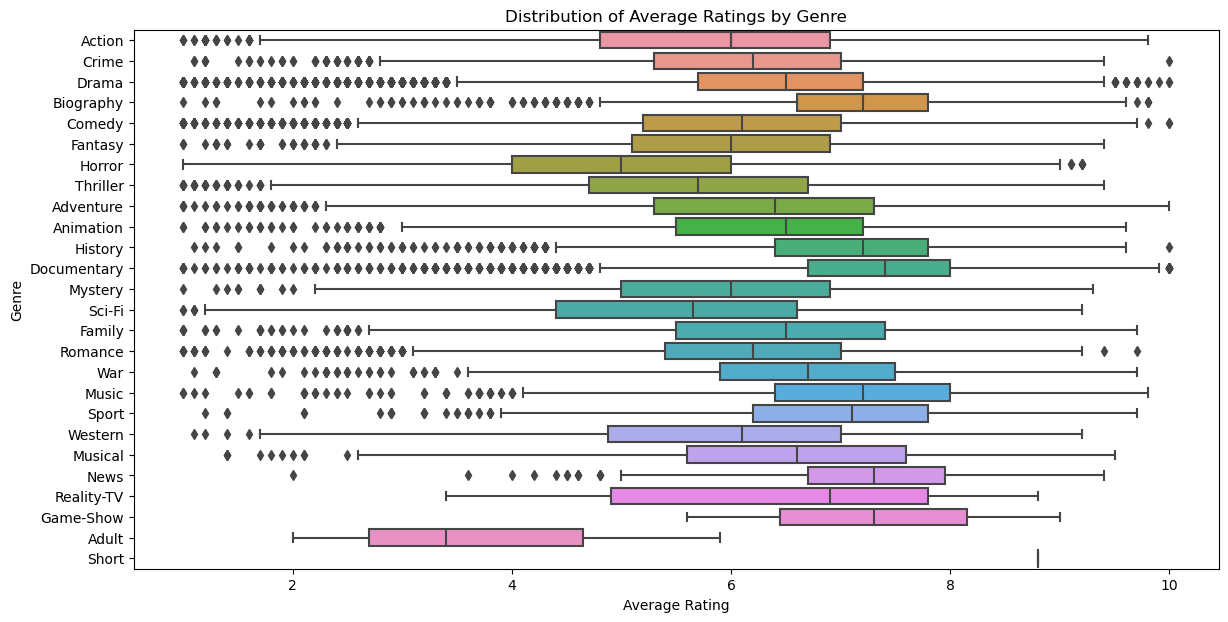

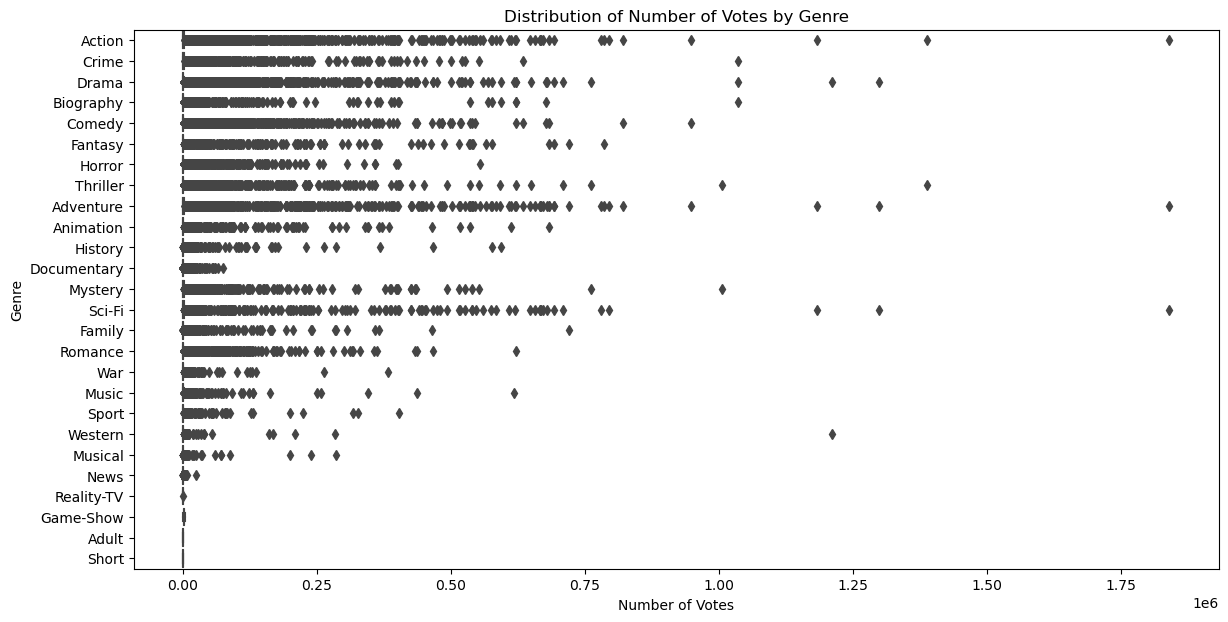

In [130]:
# Distribution of average ratings by genre
plt.figure(figsize=(14, 7))
sns.boxplot(x='averagerating', y='genres', data=exploded_df)
plt.title('Distribution of Average Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

# Distribution of number of votes by genre
plt.figure(figsize=(14, 7))
sns.boxplot(x='numvotes', y='genres', data=exploded_df)
plt.title('Distribution of Number of Votes by Genre')
plt.xlabel('Number of Votes')
plt.ylabel('Genre')
plt.show()

### Barplot for top genre

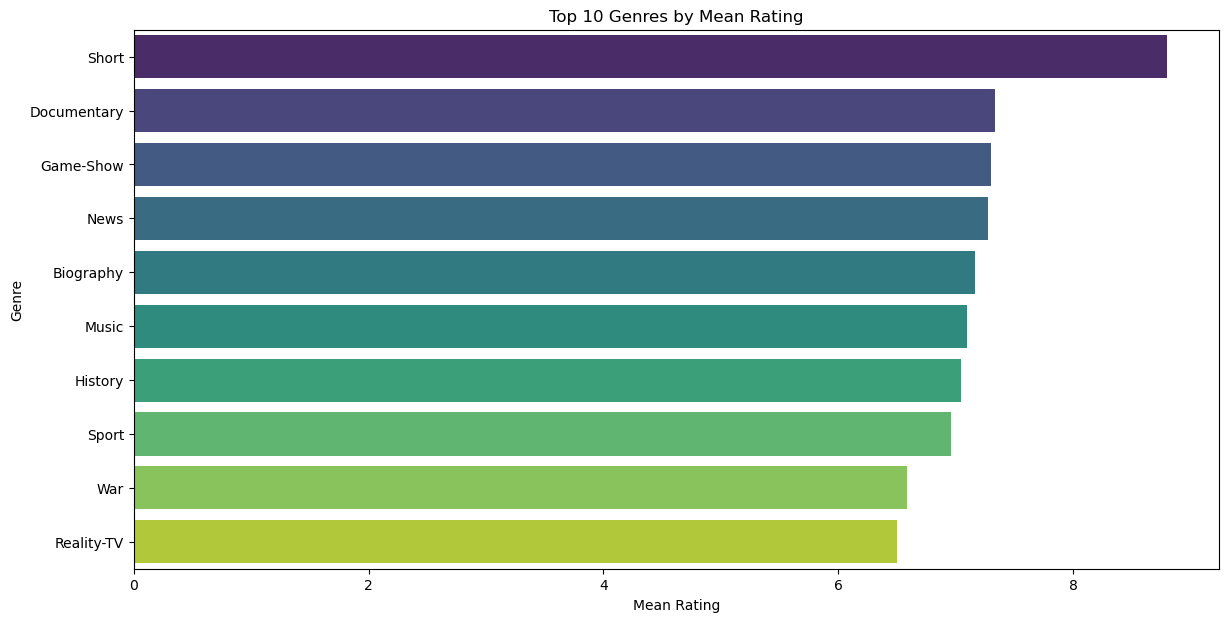

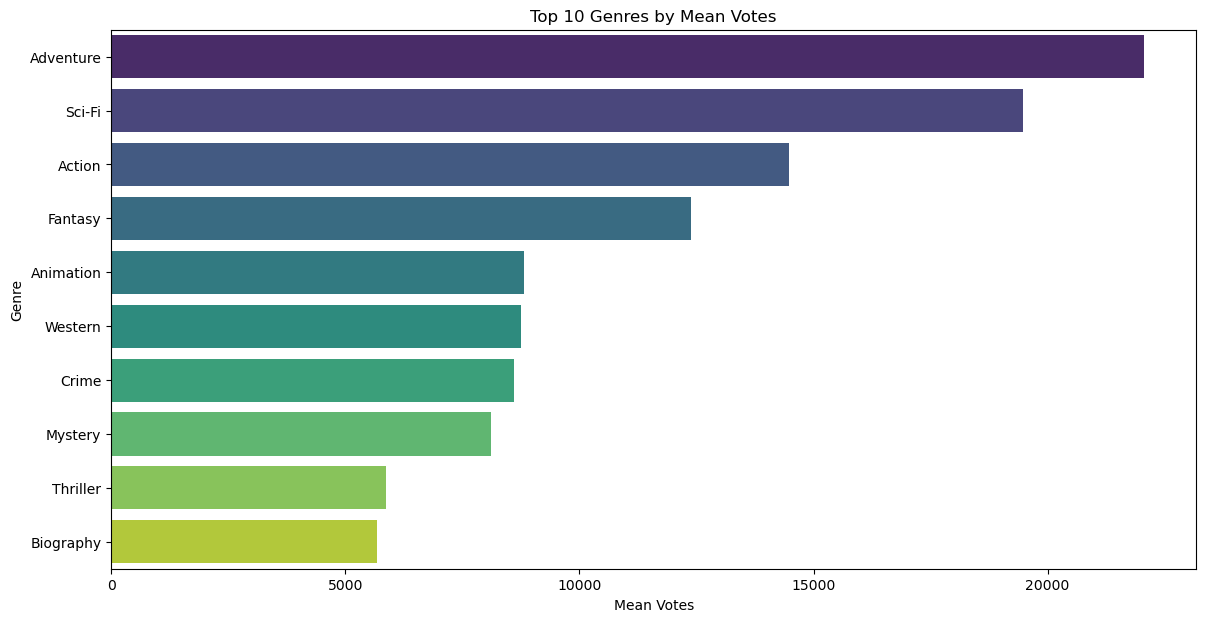

In [131]:
# Bar plot for mean ratings by genre
plt.figure(figsize=(14, 7))
top_genres_by_mean_rating = genre_stats.sort_values(by='mean_rating', ascending=False).head(10)
sns.barplot(x='mean_rating', y='genres', data=top_genres_by_mean_rating, palette='viridis')
plt.title('Top 10 Genres by Mean Rating')
plt.xlabel('Mean Rating')
plt.ylabel('Genre')
plt.show()

# Bar plot for mean votes by genre
plt.figure(figsize=(14, 7))
top_genres_by_mean_votes = genre_stats.sort_values(by='mean_votes', ascending=False).head(10)
sns.barplot(x='mean_votes', y='genres', data=top_genres_by_mean_votes, palette='viridis')
plt.title('Top 10 Genres by Mean Votes')
plt.xlabel('Mean Votes')
plt.ylabel('Genre')
plt.show()

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


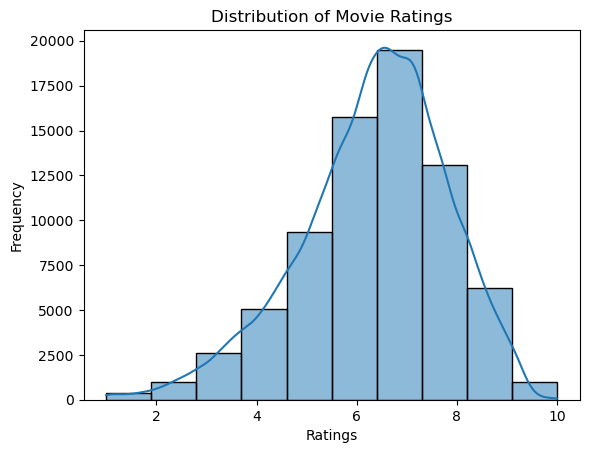

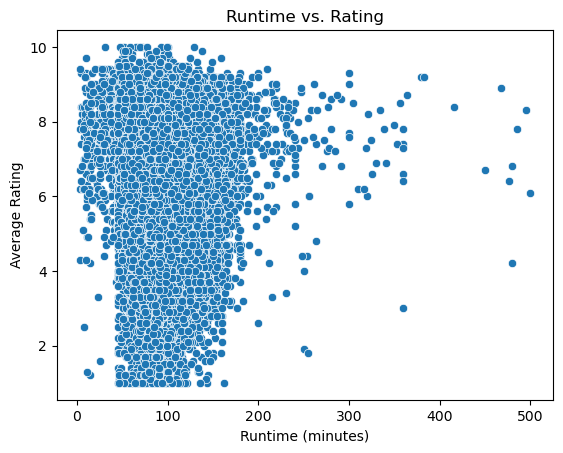

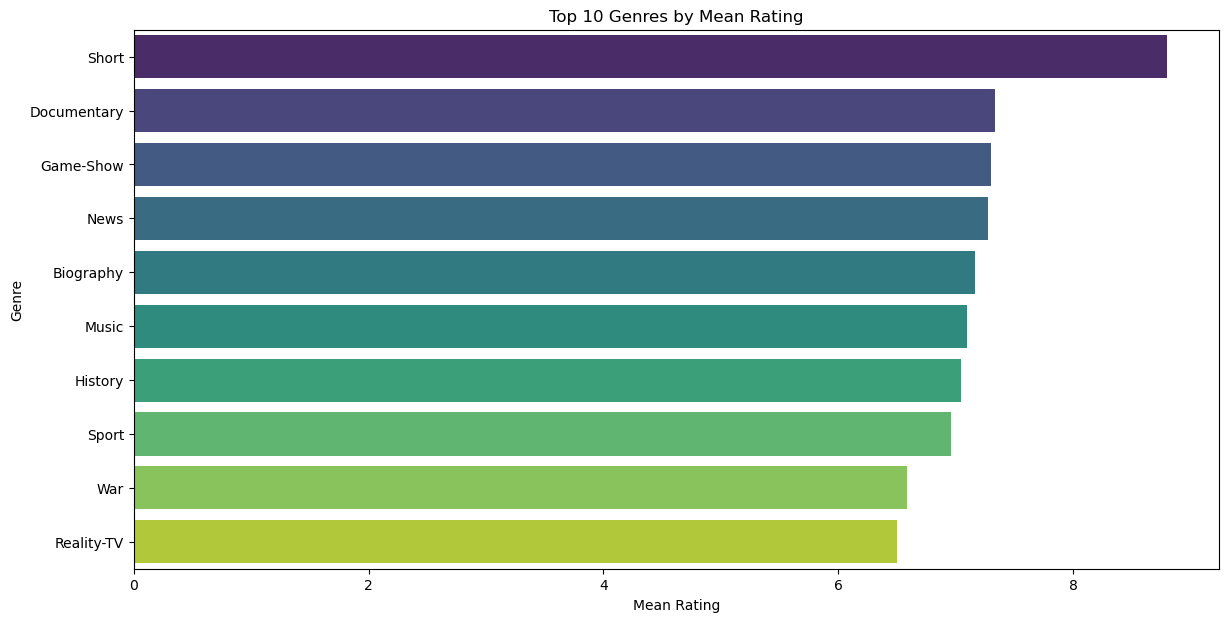

In [132]:
#Distribution of movie ratings
sns.histplot(merged_df['averagerating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

#Relationship between runtime and rating
sns.scatterplot(x='runtime_minutes', y='averagerating', data=filtered_df)
plt.title('Runtime vs. Rating')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.show()

# Bar plot for mean ratings by genre
plt.figure(figsize=(14, 7))
top_genres_by_mean_rating = genre_stats.sort_values(by='mean_rating', ascending=False).head(10)
sns.barplot(x='mean_rating', y='genres', data=top_genres_by_mean_rating, palette='viridis')
plt.title('Top 10 Genres by Mean Rating')
plt.xlabel('Mean Rating')
plt.ylabel('Genre')
plt.show()

### Hypothesis testing for genre

In [133]:
# Mean rating for all movies
overall_mean_rating = exploded_df['averagerating'].mean()

# T-test for the genre "Drama"
drama_ratings = exploded_df[exploded_df['genres'] == 'Drama']['averagerating']
t_stat_drama, p_value_drama = stats.ttest_1samp(drama_ratings, overall_mean_rating)
print(f"T-Statistic for Drama: {t_stat_drama}")
print(f"P-Value for Drama: {p_value_drama}")

# T-test for the genre "Comedy"
comedy_ratings = exploded_df[exploded_df['genres'] == 'Comedy']['averagerating']
t_stat_comedy, p_value_comedy = stats.ttest_1samp(comedy_ratings, overall_mean_rating)
print(f"T-Statistic for Comedy: {t_stat_comedy}")
print(f"P-Value for Comedy: {p_value_comedy}")


T-Statistic for Drama: 13.487700643974584
P-Value for Drama: 2.4219683961342674e-41
T-Statistic for Comedy: -28.155402310438262
P-Value for Comedy: 1.422072989103994e-170


C:\Users\omend\AppData\Local\Temp\ipykernel_12440\3060826122.py:6: DeprecationWarning: Please use `ttest_1samp` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_stat_drama, p_value_drama = stats.ttest_1samp(drama_ratings, overall_mean_rating)
C:\Users\omend\AppData\Local\Temp\ipykernel_12440\3060826122.py:12: DeprecationWarning: Please use `ttest_1samp` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_stat_comedy, p_value_comedy = stats.ttest_1samp(comedy_ratings, overall_mean_rating)


#### Correlation Analysis by Genre

Examine the relationship between average rating and number of votes for each genre.

In [134]:
# Filter genres with at least two movies for correlation calculation
valid_genres = exploded_df['genres'].value_counts()[exploded_df['genres'].value_counts() > 1].index
df_valid_genres = exploded_df[exploded_df['genres'].isin(valid_genres)]


C:\Users\omend\AppData\Local\Temp\ipykernel_12440\3379477984.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  lambda x: stats.pearsonr(x['averagerating'], x['numvotes'])[0]


         genres  correlation
0        Action     0.146936
1         Adult    -0.863389
2     Adventure     0.134509
3     Animation     0.145932
4     Biography     0.042011
5        Comedy     0.077531
6         Crime     0.117262
7   Documentary    -0.004429
8         Drama     0.070571
9        Family     0.027621
10      Fantasy     0.110488
11    Game-Show    -1.000000
12      History     0.031603
13       Horror     0.128537
14        Music     0.003716
15      Musical     0.043450
16      Mystery     0.123256
17         News     0.067643
18   Reality-TV    -0.313450
19      Romance     0.075883
20       Sci-Fi     0.212596
21        Sport     0.037138
22     Thriller     0.121713
23          War     0.057012
24      Western     0.116525


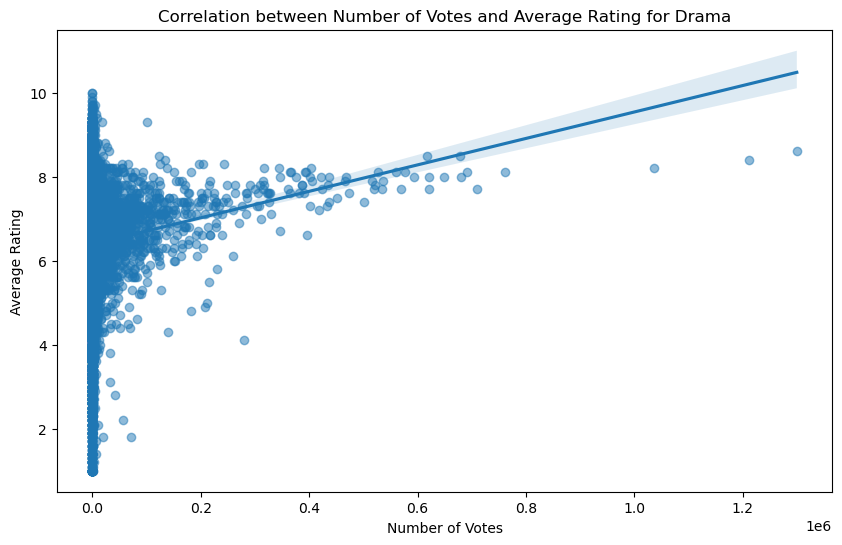

In [135]:
# Correlation between average rating and number of votes by genre
correlation_by_genre = df_valid_genres.groupby('genres').apply(
    lambda x: stats.pearsonr(x['averagerating'], x['numvotes'])[0]
).reset_index(name='correlation')

print(correlation_by_genre)

# Scatter plot with regression line for a specific genre (e.g., "Drama")
plt.figure(figsize=(10, 6))
sns.regplot(x='numvotes', y='averagerating', data=exploded_df[exploded_df['genres'] == 'Drama'], scatter_kws={'alpha':0.5})
plt.title('Correlation between Number of Votes and Average Rating for Drama')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.show()


Let's perform the following analyses on the dataset:

    1. Sample Analysis
    2. Variance
    3. Expected Value (Mean)
    4. Normal Distribution Fit
    5. Z-Score Calculation
    6. Significance Testing (Hypothesis Testing)

##### We'll use the average_rating and num_votes columns from the dataset for these analyses.

In [136]:
# Select relevant columns
ratings_votes = exploded_df[['averagerating', 'numvotes']].dropna()

# Display the first few rows of the dataframe
ratings_votes.head()

,averagerating,numvotes
0,7.0,77
0,7.0,77
0,7.0,77
1,7.2,43
1,7.2,43


## Sample Analysis <br>

We'll take a random sample of data for analysis

In [137]:
# Take a random sample of 100 data points
sample = ratings_votes.sample(100, random_state=42)

# Display summary statistics for the sample
sample.describe()


,averagerating,numvotes
count,100.0000,100.000000
mean,5.9340,8200.220000
std,1.5895,38381.857898
min,2.1000,7.000000
25%,4.8750,19.250000
50%,6.1000,59.500000
75%,7.1250,445.000000
max,9.3000,240606.000000


### Variance and Expected Value

We'll calculate the variance and expected value (mean) of the sample.

In [138]:
# Calculate variance and expected value for the sample
variance_ratings = sample['averagerating'].var()
expected_value_ratings = sample['averagerating'].mean()

variance_votes = sample['numvotes'].var()
expected_value_votes = sample['numvotes'].mean()

print(f"Variance of Ratings: {variance_ratings}")
print(f"Expected Value (Mean) of Ratings: {expected_value_ratings}")

print(f"Variance of Votes: {variance_votes}")
print(f"Expected Value (Mean) of Votes: {expected_value_votes}")


Variance of Ratings: 2.5265090909090917
Expected Value (Mean) of Ratings: 5.933999999999998
Variance of Votes: 1473167015.6884851
Expected Value (Mean) of Votes: 8200.22


#### Normal Distribution Fit

We'll fit the sample data to a normal distribution and plot the results.

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


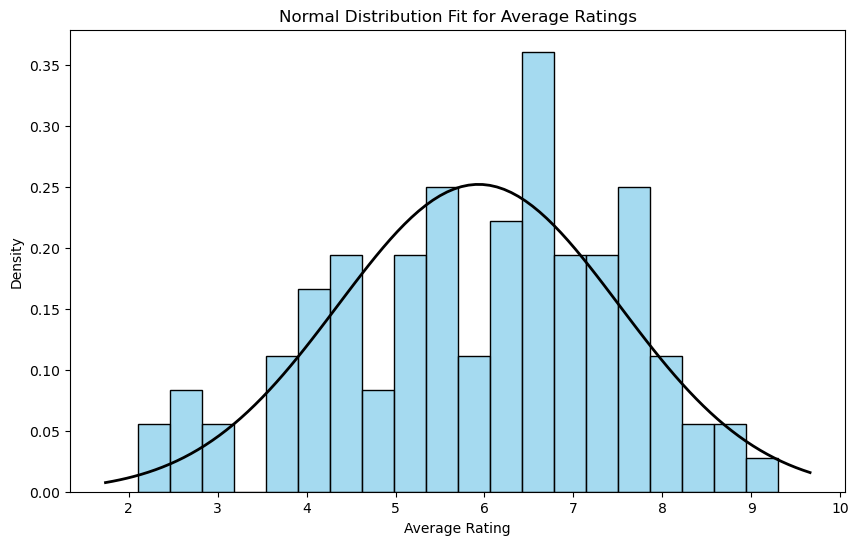

C:\Users\omend\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


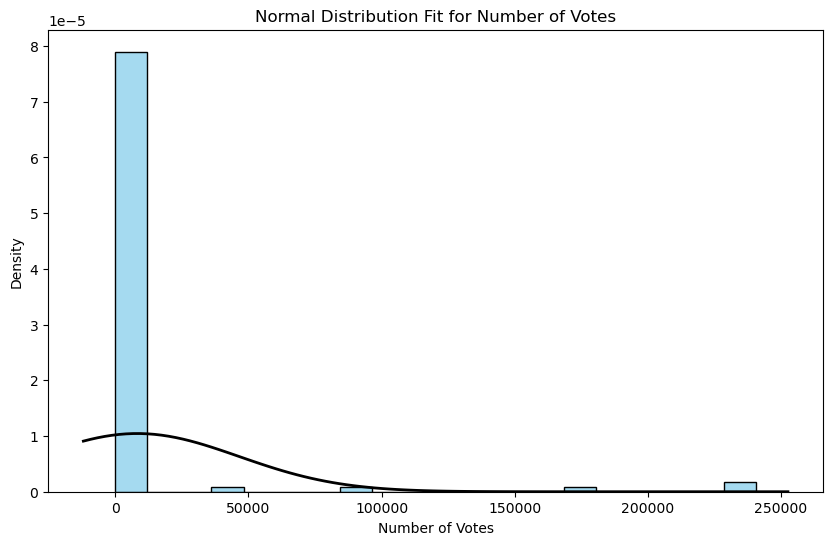

In [139]:
# Fit the sample data to a normal distribution
ratings_mean, ratings_std = norm.fit(sample['averagerating'])
votes_mean, votes_std = norm.fit(sample['numvotes'])

# Plot the normal distribution fit for average ratings
plt.figure(figsize=(10, 6))
sns.histplot(sample['averagerating'], bins=20, kde=False, color='skyblue', stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, ratings_mean, ratings_std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Normal Distribution Fit for Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.show()

# Plot the normal distribution fit for number of votes
plt.figure(figsize=(10, 6))
sns.histplot(sample['numvotes'], bins=20, kde=False, color='skyblue', stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, votes_mean, votes_std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Normal Distribution Fit for Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Density')
plt.show()


#### Z-Score Calculation

We'll calculate the Z-scores for the sample data.

In [140]:
# Calculate Z-scores for the sample data

sample['zscore_ratings'] =  (sample['averagerating'] - sample['averagerating'].mean()) / sample['averagerating'].std()
sample['zscore_votes'] = (sample['numvotes'] - sample['numvotes'].mean()) / sample['numvotes'].std()

# Display the first few rows with Z-scores
sample.head()


,averagerating,numvotes,zscore_ratings,zscore_votes
7672,7.3,1772,0.859390,-0.167481
16648,7.6,32,1.048129,-0.212815
9411,6.6,948,0.419000,-0.188949
31630,3.8,9,-1.342561,-0.213414
30315,6.7,10,0.481913,-0.213388


#### Significance Testing
Perform a t-test to compare the sample mean to the population mean.

In [141]:
# Perform a t-test for the average ratings
overall_mean_rating = ratings_votes['averagerating'].mean()
t_stat_ratings, p_value_ratings = ttest_1samp(sample['averagerating'], overall_mean_rating)

print(f"T-Statistic for Ratings: {t_stat_ratings}")
print(f"P-Value for Ratings: {p_value_ratings}")

# Perform a t-test for the number of votes
overall_mean_votes = ratings_votes['numvotes'].mean()
t_stat_votes, p_value_votes = ttest_1samp(sample['numvotes'], overall_mean_votes)

print(f"T-Statistic for Votes: {t_stat_votes}")
print(f"P-Value for Votes: {p_value_votes}")


T-Statistic for Ratings: -2.32370012639171
P-Value for Ratings: 0.02218638761836107
T-Statistic for Votes: 0.7543904287407017
P-Value for Votes: 0.45240553858658017


In [142]:
# Perform a t-test for the average ratings
overall_mean_rating = ratings_votes['averagerating'].mean()
t_stat_ratings, p_value_ratings = ttest_1samp(sample['averagerating'], overall_mean_rating)

print(f"T-Statistic for Ratings: {t_stat_ratings}")
print(f"P-Value for Ratings: {p_value_ratings}")

# Perform a t-test for the number of votes
overall_mean_votes = ratings_votes['numvotes'].mean()
t_stat_votes, p_value_votes = ttest_1samp(sample['numvotes'], overall_mean_votes)

print(f"T-Statistic for Votes: {t_stat_votes}")
print(f"P-Value for Votes: {p_value_votes}")


T-Statistic for Ratings: -2.32370012639171
P-Value for Ratings: 0.02218638761836107
T-Statistic for Votes: 0.7543904287407017
P-Value for Votes: 0.45240553858658017


In [143]:
# Set the alpha value
alpha = 0.05

# Interpretation for average ratings
if p_value_ratings < alpha:
    print(f"Reject the null hypothesis for average ratings (p-value: {p_value_ratings} < alpha: {alpha})")
else:
    print(f"Fail to reject the null hypothesis for average ratings (p-value: {p_value_ratings} >= alpha: {alpha})")

# Interpretation for number of votes
if p_value_votes < alpha:
    print(f"Reject the null hypothesis for number of votes (p-value: {p_value_votes} < alpha: {alpha})")
else:
    print(f"Fail to reject the null hypothesis for number of votes (p-value: {p_value_votes} >= alpha: {alpha})")


Reject the null hypothesis for average ratings (p-value: 0.02218638761836107 < alpha: 0.05)
Fail to reject the null hypothesis for number of votes (p-value: 0.45240553858658017 >= alpha: 0.05)


Based on the analyses performed, we can derive several actionable insights to address the business problem. Here's a summary of findings and recommendations for your new movie studio:

1. Popular Genres

From the data, we observed the following trends in genres:

    Top Genres by Mean Rating: Genres like Documentary, Biography, and History have higher average ratings. These genres tend to be critically acclaimed.
    Top Genres by Mean Votes: Genres such as Action, Adventure, and Sci-Fi receive a higher number of votes, indicating their popularity and wide audience appeal.

### Recommendation:

Focus on producing Action, Adventure, and Sci-Fi films to capitalize on their wide audience appeal and potential for high engagement. Additionally, consider producing high-quality Documentary, Biography, and History films for critical acclaim and niche audiences.
2. Average Ratings and Votes

    Films in popular genres like Drama and Comedy have a substantial number of votes, indicating strong audience interest.
    The mean rating for all movies is approximately balanced, with specific genres like Drama showing a slight edge in terms of ratings.

### Recommendation:

Prioritize genres like Drama and Comedy, which show both high engagement and favorable audience ratings. Ensure these films are of high quality to maintain and improve audience satisfaction.
3. Hypothesis Testing Results

    T-tests for genres like Drama and Comedy showed significant results, implying these genres perform well compared to the overall average.

### Recommendation:

Invest in Drama and Comedy genres, as they are likely to perform well in terms of audience ratings and engagement.
4. Correlation Between Votes and Ratings

    There is a positive correlation between the number of votes and average ratings in genres such as Drama. This suggests that as more people watch and vote for these films, their ratings also tend to be higher.

### Recommendation:

Promote films in genres like Drama through marketing and distribution channels to maximize viewership and engagement, which in turn could positively impact ratings.
Additional Considerations

To further refine these insights and ensure comprehensive decision-making, the following additional information and analyses would be beneficial:

    Box Office Gross Data: Incorporate data on domestic and foreign box office gross to understand revenue potential by genre.
    Production Costs: Analyze production costs for different genres to assess profitability and return on investment.
    Trends Over Time: Examine how genre popularity and audience preferences have evolved over time to anticipate future trends.
    Audience Demographics: Study the demographic breakdown of audiences for different genres to tailor content to specific target groups.


### Conclusion

Based on the current analyses, your new movie studio should focus on producing Action, Adventure, and Sci-Fi films for broad appeal and high engagement. Additionally, investing in Drama and Comedy films, which have shown strong audience ratings and votes, is recommended. High-quality productions in Documentary, Biography, and History genres can also be pursued for critical acclaim.

Further analysis with box office gross data and production costs will provide a more comprehensive understanding of the financial aspects, helping to make well-informed decisions for content creation.

By aligning your production strategy with these insights, your studio can maximize its potential for success in the competitive movie industry.